<a href="https://colab.research.google.com/github/fzanart/Cookbook/blob/main/Huggingface/Github_domains.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#%%capture
!pip install datasets
!pip install transformers[sentencepiece]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
%%capture
!wget https://github.com/fzanart/GHDomains/raw/main/expanded_frame_final.csv.zip

In [3]:
#%%capture
!unzip /content/expanded_frame_final.csv.zip

Archive:  /content/expanded_frame_final.csv.zip
replace expanded_frame_final.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/._expanded_frame_final.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [4]:
import pandas as pd
import numpy as np
from datasets import Dataset,DatasetDict, Value, ClassLabel, Features
from transformers import AutoModelForSequenceClassification,AutoTokenizer, Trainer, TrainingArguments
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, confusion_matrix, classification_report


In [5]:
df = pd. read_csv('/content/expanded_frame_final.csv', usecols=['Description', 'Domain']) #TODO: find and filter columns data #'Languages'
df = df[~df['Description'].isnull()].reset_index(drop=True)
df['Domain'] = df['Domain'].replace(['System software','Application software'], 'Application & System software')
df = df.rename(columns={"Description": "text", "Domain": "label"})
df['text'] = df['text'].apply(str)
features = Features({"text": Value("string"), "label": ClassLabel(num_classes=5, names=['Application & System software', 'Documentation', 'Non-web libraries and frameworks', 'Software tools', 'Web libraries and frameworks'])})
ds = Dataset.from_pandas(df, features=features)
ds_train_test = ds.train_test_split(test_size=0.2, stratify_by_column="label")
ds_test_valid = ds_train_test['test'].train_test_split(test_size=0.5, stratify_by_column="label")
ds = DatasetDict({'train':ds_train_test['train'], 'test':ds_test_valid['train'], 'valid':ds_test_valid['test']})
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 3941
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 493
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 493
    })
})

In [6]:
ds.set_format(type='pandas')
df = ds['train'][:]

def label_int2str(row):
  return ds['train'].features['label'].int2str(row)

df['label_name'] = df['label'].apply(label_int2str)
df.head()

,text,label,label_name
0,A collection of loading spinners animated with...,4,Web libraries and frameworks
1,Graphene is a realtime dashboard & graphing to...,4,Web libraries and frameworks
2,Here’s a flowchart to make you happy again!,1,Documentation
3,"EventMachine: fast, simple event-processing li...",2,Non-web libraries and frameworks
4,A high performance Node.js Redis client.,2,Non-web libraries and frameworks


In [7]:
df['label_name'].value_counts(ascending=True)

Documentation                        338
Application & System software        484
Software tools                       768
Non-web libraries and frameworks    1137
Web libraries and frameworks        1214
Name: label_name, dtype: int64

In [8]:
df_test = ds['test'][:]
df_test['label_name'] = df['label'].apply(label_int2str)
df_test['label_name'].value_counts(ascending=True)

Documentation                        46
Application & System software        62
Software tools                       95
Web libraries and frameworks        142
Non-web libraries and frameworks    148
Name: label_name, dtype: int64

In [9]:
df_valid = ds['valid'][:]
df_valid['label_name'] = df['label'].apply(label_int2str)
df_valid['label_name'].value_counts(ascending=True)

Documentation                        46
Application & System software        62
Software tools                       95
Web libraries and frameworks        142
Non-web libraries and frameworks    148
Name: label_name, dtype: int64

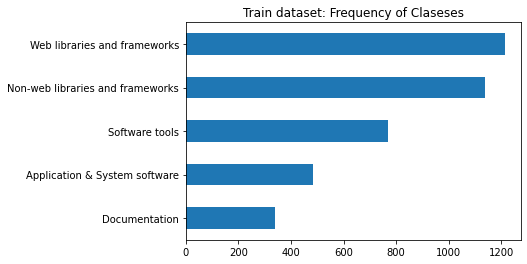

In [10]:
df['label_name'].value_counts(ascending=True).plot.barh()
plt.title('Train dataset: Frequency of Claseses')
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


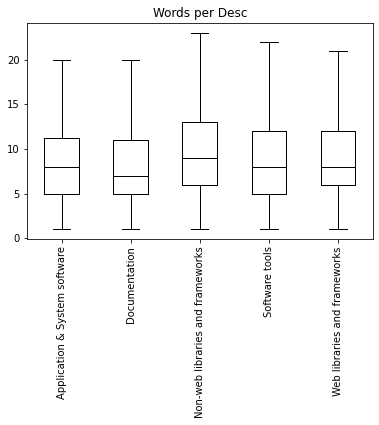

In [11]:
df['Words per Desc'] = df['text'].str.split().apply(len)
df.boxplot('Words per Desc', by='label_name', grid=False, showfliers=False, color='black', rot=90)
plt.suptitle("")
plt.xlabel("")
plt.show()

In [12]:
num_labels = 5
model_ckpt = 'microsoft/deberta-v3-small'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/578 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/286M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-small were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.classifier.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from 

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.7/dist-packages/transformers/convert_slow_tokenizer.py:447: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [13]:
def tokenize(batch):
  return tokenizer(batch['text'], padding=True, truncation=True)

In [14]:
ds.reset_format()
ds_encoded = ds.map(tokenize, batched=True, batch_size=None)
print(ds_encoded['train'].column_names)
ds_encoded.set_format('torch', columns=['input_ids', 'attention_mask','label'])

  0%|          | 0/1 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask']


In [15]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average='weighted')
  acc = accuracy_score(labels, preds)
  return {'accuraccy': acc, 'f1':f1}


In [16]:
bs = 32 #batch size
epochs = 4
lr = 8e-5
logging_steps = len(ds_encoded['train']) // bs

args = TrainingArguments('outputs', 
                         num_train_epochs=epochs, 
                         learning_rate=lr, 
                         per_device_train_batch_size=bs, 
                         per_device_eval_batch_size=bs,
                         weight_decay=0.01, 
                         evaluation_strategy="epoch",
                         logging_steps=logging_steps)

In [17]:
trainer = Trainer(model=model, args=args, compute_metrics=compute_metrics, train_dataset = ds_encoded['train'], eval_dataset = ds_encoded['valid'], tokenizer=tokenizer)
trainer.train();

The following columns in the training set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3941
  Num Epochs = 4
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 496
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed b

Epoch,Training Loss,Validation Loss,Accuraccy,F1
1,1.364000,1.135415,0.488844,0.443394
2,1.045400,1.081427,0.586207,0.576849
3,0.740900,0.997392,0.659229,0.652451
4,0.514300,1.037582,0.667343,0.668577


The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 493
  Batch size = 32
/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:746: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scale, dtype=query_layer.dtype
/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:829: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  score += c2p_att / torch.tensor(scale, 

In [25]:
pred_output = trainer.predict(ds_encoded['valid'])

The following columns in the test set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 493
  Batch size = 32
/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:746: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scale, dtype=query_layer.dtype
/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:829: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  score += c2p_att / torch.tensor(scale, dtype=

In [26]:
pred_output.metrics

{'test_loss': 1.0375818014144897,
 'test_accuraccy': 0.6673427991886409,
 'test_f1': 0.6685773738298167,
 'test_runtime': 2.1912,
 'test_samples_per_second': 224.994,
 'test_steps_per_second': 7.302}

In [27]:
y_preds = np.argmax(pred_output.predictions, axis =1)

In [28]:
def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize='true')
  fig, ax = plt.subplots(figsize=(6,6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False, xticks_rotation='vertical')
  plt.title('Normalized confusion matrix')
  plt.show()

In [29]:
labels = ds['train'].features['label'].names
y_valid = ds['valid']['label']

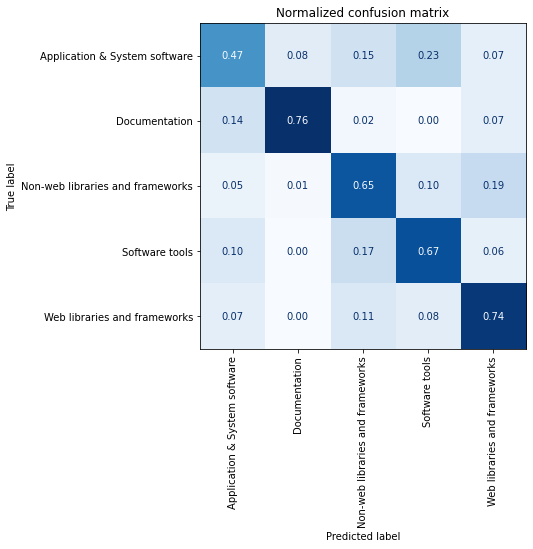

In [30]:
plot_confusion_matrix(y_preds, y_valid, labels)

In [31]:
print(classification_report(y_valid, y_preds, target_names=labels))

                                  precision    recall  f1-score   support

   Application & System software       0.45      0.47      0.46        60
                   Documentation       0.84      0.76      0.80        42
Non-web libraries and frameworks       0.68      0.65      0.67       143
                  Software tools       0.61      0.67      0.64        96
    Web libraries and frameworks       0.74      0.74      0.74       152

                        accuracy                           0.67       493
                       macro avg       0.66      0.66      0.66       493
                    weighted avg       0.67      0.67      0.67       493

